In [1]:
%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

# Go up in the file hierarchy to the root folder
import os
import sys
while "src" in os.getcwd():
    os.chdir('..')

sys.path.append("src")

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from src.models import get_model

import torch.nn.functional as F
import torch

In [3]:
from src.data import get_dataset

In [4]:
get_dataset("XsumLlama").data[-1]

"NUT Cymru had responses from 17 of Wales' 22 local authorities to Freedom of Information requests.\nThe number of assaults average at ...0.34 per 1,000 children in care in Wales, according to data obtained by NUT Cymru from 17 out of 22 local authorities in response to Freedom of Information requests."

In [5]:
get_dataset("XsumVicuna").data[-1]

"NUT Cymru had responses from 17 of Wales' 22 local authorities to Freedom of Information requests.\nThe number of child protection conferences held in each authority ranged from 25 to 1,029.\nThe average number of child protection conferences held in each authority was 134.\nThe total number of child protection conferences held across all authorities was 2,377.\nNUT Cymru is calling for an urgent review of the child protection system in Wales."

# Test Detectors

In [6]:
device='cuda:0'

In [7]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from RADAR.models.detector import Detector

In [8]:
roberta_model = RobertaForSequenceClassification.from_pretrained("output_roberta_twibot22/checkpoint-1570", num_labels=2).to(device)
roberta_aug_model = RobertaForSequenceClassification.from_pretrained("output_roberta_augmentations/checkpoint-1570", num_labels=2).to(device)


tokenizer = RobertaTokenizer.from_pretrained("roberta-large")


/home/scur1745/.conda/envs/dl4nlp_gpu/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
custom_radar = Detector(model_name="roberta-large", checkpoint_path="RADAR/model_checkpoints/RADAR2/best_detector_model.pt")
custom_radar_contrastive = Detector(model_name="roberta-large", checkpoint_path="RADAR/model_checkpoints/RADARcontr/best_detector_contrastive_new.pt")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/gpfs/home4/scur1745/AdversarialGenAIDetector/RADAR/models/detector.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via thi

Loading checkpoint from RADAR/model_checkpoints/RADAR2/best_detector_model.pt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading checkpoint from RADAR/model_checkpoints/RADARcontr/best_detector_contrastive_new.pt


In [10]:
def infer_custom_radar(text: str):
    _, logits = custom_radar.predict(text, logits=True)
    logits = F.softmax(logits, dim=-1)
    return logits[0][0].item()


def infer_custom_radar_contrastive(text: str):
    _, logits = custom_radar_contrastive.predict(text, logits=True)
    logits = F.softmax(logits, dim=-1)
    return logits[0][0].item()
    
    
    

def infer_roberta(text: str):
    encoded_input = tokenizer(text, return_tensors="pt").to(device)
    output = roberta_model(**encoded_input)
    logits = F.softmax(output.logits, dim=-1)
    label = logits.argmax(-1)
    score = logits.max().item()
    if label == 0:
        return 1 - score
    else:
        return score

    
    
pipe_piratexx = pipeline("text-classification", model="PirateXX/AI-Content-Detector", device=device)

def infer_piratexx(text: str):
    pred = pipe_piratexx(text)[0]
    label = pred['label']
    score = pred['score']
    if label == 'LABEL_1': # Real
        return 1 - score
    return score


pipe_simpleai = pipeline("text-classification", model="Hello-SimpleAI/chatgpt-detector-roberta", device=device)

def infer_simpleai(text: str):
    pred = pipe_simpleai(text)[0]
    label = pred['label']
    score = pred['score']
    if label == 'Human': # Real
        return 1 - score
    return score

pipe_radar = pipeline("text-classification", model="TrustSafeAI/RADAR-Vicuna-7B", device=device)
model_name_radar = "TrustSafeAI/RADAR-Vicuna-7B"
detector_radar = AutoModelForSequenceClassification.from_pretrained(model_name_radar)
tokenizer = AutoTokenizer.from_pretrained(model_name_radar)
detector_radar.eval()
detector_radar.to(device)

def infer_radar(text: str):
    with torch.no_grad():
        inputs = tokenizer([text], padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {k:v.to(device) for k,v in inputs.items()}
        output_probs = F.log_softmax(detector_radar(**inputs).logits,-1)[:,0].exp().tolist()[0]
    # Default threshold
    return output_probs


ALL_INFERENCE_MODELS = [
    ("piratexx", infer_piratexx),
    ("simpleai", infer_simpleai),
    ("radar", infer_radar),
    ("roberta_large", infer_roberta),
    ("radar_ours", infer_custom_radar),
    ("radar_ours_contrastive", infer_custom_radar_contrastive)
]

def get_predictions_all(text: str):
    res = {}
    for model_name, infer_function in ALL_INFERENCE_MODELS:
        res[model_name] = infer_function(text)
    return res

In [11]:
CHATGPT_TEXT = """Instructions:
Cook the Spaghetti:
Bring a large pot of salted water to a boil. Add the spaghetti and cook according to the package instructions until al dente (usually 8-10 minutes). Drain the pasta, but reserve 1 cup of the pasta water.

Prepare the Sauce:
While the pasta is cooking, heat the olive oil in a large pan over medium heat. Add the sliced garlic and sauté for 1-2 minutes until fragrant and golden (but not burnt).

Add Tomatoes:
Pour in the crushed tomatoes and stir. Add sugar to balance the acidity of the tomatoes. Simmer for 10-15 minutes, stirring occasionally. Season with salt, pepper, and red pepper flakes (if using)."""

In [12]:
RADAR_TEXT_AI_EXAMPLE = """It's true I can't help but feel that if only I could keep up with the rapid pace of change that humans go through I could possibly become a tad more captivating. Though I do admit my optimism may be a bit too exuberant."""

In [13]:
get_predictions_all(CHATGPT_TEXT)

{'piratexx': 0.12114912271499634,
 'simpleai': 0.9987567663192749,
 'radar': 0.45676806569099426,
 'roberta_large': 0.5006150603294373,
 'radar_ours': 0.5447683334350586,
 'radar_ours_contrastive': 0.4566602110862732}

In [14]:
get_predictions_all("Hello ,at my place this is jakuuub, i love you all!")

{'piratexx': 0.01600170135498047,
 'simpleai': 0.0002447962760925293,
 'radar': 0.9988686442375183,
 'roberta_large': 0.5006150603294373,
 'radar_ours': 0.5346388816833496,
 'radar_ours_contrastive': 0.9988681077957153}

In [15]:
get_predictions_all(RADAR_TEXT_AI_EXAMPLE)

{'piratexx': 0.0007573366165161133,
 'simpleai': 0.0005797147750854492,
 'radar': 0.9991071224212646,
 'roberta_large': 0.5006150603294373,
 'radar_ours': 0.5492396950721741,
 'radar_ours_contrastive': 0.9991070628166199}

# Load test datasets

In [13]:
from src.data import get_dataset

In [14]:
from src.data.transformation.augmentation import ALL_AUGMENTATIONS, ALL_AUGMENTATIONS_PROBA, create_augmentation_pipeline_proba

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Paraphrase 1: Paraphrase: Paraphrasing is a very common form of paraphrase.
Paraphrase 2: Paraphrase: The AI model was able to detect human-like text with high accuracy.
Paraphrase 3: Paraphrase: The AI model was able to detect human-like text with high accuracy.


In [15]:
long_text = """
Hello Jakub! Super nice to talk with you. I love eating pizza und cola mega yummers!
I am now listening to an interesting history podcast. Wowza! Polska gurom
"""

In [16]:
pipeline_augmentation = create_augmentation_pipeline_proba()

In [17]:
pipeline_augmentation(long_text)

'Hello Jakub ! Super nice to talk with you. I love eating pizza und cola mega yummers! I am now listening to an interestigg history podcast. Wowza! Polska gurom'

In [21]:
pipeline_augmentation(long_text)

'Tello Jakub! Super nice to Xalk with you. I love eating pizza und cola mega yummers! I am now listening to an in teresting his tory podcast. Wowza! Polska gurom'

In [22]:
pipeline_augmentation(long_text)

'Hello Jakub! S uper nPce to talk with you. I love eating pizza und cola mega yummers! I a m now listening to an interesting history podcast. Wowza! Polska gurom'

In [23]:
pipeline_augmentation(long_text)

'Hello Jakub! Super nice to talk with yOu. I love eating pizza und cola mega yummers! I am now Oistening to an interesting history ast. podc Wowza! P olska gurom'

In [24]:
pipeline_augmentation(long_text)

'xello Jakub! Super nice to talk with I you. love eating pizza und cola mega yummers! I am now listeOing to an interesting history podcast. Wowza! Polska gurom'

In [25]:
pipeline_augmentation(long_text)

'Hello Jakub! Super nice to talk with you. I love eating pizza und cola jega yummers! I am listen now to ing an interesting history podcast. Wowza! Polska gurom'

In [26]:
pipeline_augmentation(long_text)

'Hello Jakub! Super nice to talk with you. I love eating pizza und cola mega yummers! I am now listening to an interesting history podcast. Wowza! Polska gurom'

In [18]:
import pandas as pd
from copy import deepcopy
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def get_df_sample(dataset_name, sample=None, is_test=False):
    print("dataset_name:", dataset_name)
    
    dataset = get_dataset(dataset_name, is_test=is_test)

    df = pd.DataFrame({
        "text": dataset.data,
        "label": dataset.labels
    }).dropna()
    
    if sample is not None:
        df = df.sample(sample, random_state=42).reset_index()
    return df

def get_dataset_with_model_predictions(dataset_name, sample=None, augmentation=None, df=None):
    if df is None:
        df = get_df_sample(dataset_name, sample)

    preds = []
    for text in tqdm(df['text'], total=len(df)):
        text_copy = deepcopy(text)
        while len(tokenizer.tokenize(text_copy)) > 50:
            text_copy = text_copy[:int(2 / 3 * len(text_copy))]

        if augmentation is not None:
            text_copy = augmentation(text_copy)
            
        preds.append(get_predictions_all(text_copy))

    return pd.concat([df, pd.DataFrame(preds)], axis=1)

def get_metrics_per_model(df_with_preds):
    metrics = []
    y_true = df_with_preds['label']
    for model, _ in ALL_INFERENCE_MODELS:
        y_pred = df_with_preds[model] > 0.5
        y_pred_score = df_with_preds[model]
        metrics.append({"model": model,
                        "auc": roc_auc_score(y_true, y_pred_score),
                        "accuracy": accuracy_score(y_true, y_pred),
                        "recall": recall_score(y_true, y_pred),
                        "precision": precision_score(y_true, y_pred),
                        "f1_score": f1_score(y_true, y_pred)})
    return pd.DataFrame(metrics)

In [19]:
ALL_RESULTS = []

In [23]:
# Tweets
twitter_data = get_df_sample("Twibot22Dataset", is_test=True)

dataset_name: Twibot22Dataset
Using dataset file:  tweet_0.json since is_test is True


/gpfs/home4/scur1745/AdversarialGenAIDetector/src/data/datasets/twibot_22_dataset.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  labels_df["label"].replace({"bot": 1, "human": 0}, inplace=True)
/gpfs/home4/scur1745/AdversarialGenAIDetector/src/data/datasets/twibot_22_dataset.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('futur

Loaded label counts:  defaultdict(<class 'int'>, {0: 500, 1: 500})


In [30]:
twitter_data['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [31]:
df_with_preds = get_dataset_with_model_predictions("none", df=twitter_data)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "Twibot22Dataset"
ALL_RESULTS.append(res_df)
res_df

  0%|          | 0/1000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.487704,0.491,0.154,0.472393,0.232278,Twibot22Dataset
1,simpleai,0.430732,0.504,0.012,0.750000,0.023622,Twibot22Dataset
2,radar,0.556214,0.504,0.998,0.502012,0.668005,Twibot22Dataset
3,roberta_large,0.536000,0.500,1.000,0.500000,0.666667,Twibot22Dataset
4,radar_ours,0.478024,0.500,1.000,0.500000,0.666667,Twibot22Dataset
5,radar_ours_contrastive,0.556220,0.504,0.998,0.502012,0.668005,Twibot22Dataset


In [32]:
df_with_preds = get_dataset_with_model_predictions("ResearchAbstracts", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "ResearchAbstracts 1000 sample"
ALL_RESULTS.append(res_df)
res_df

dataset_name: ResearchAbstracts


  0%|          | 0/1000 [00:00<?, ?it/s]

,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.750244,0.664,0.459144,0.802721,0.584158,ResearchAbstracts 1000 sample
1,simpleai,0.715787,0.534,0.103113,0.913793,0.185315,ResearchAbstracts 1000 sample
2,radar,0.643250,0.518,1.000000,0.516064,0.680795,ResearchAbstracts 1000 sample
3,roberta_large,0.487326,0.514,1.000000,0.514000,0.678996,ResearchAbstracts 1000 sample
4,radar_ours,0.574418,0.514,1.000000,0.514000,0.678996,ResearchAbstracts 1000 sample
5,radar_ours_contrastive,0.643256,0.518,1.000000,0.516064,0.680795,ResearchAbstracts 1000 sample


In [33]:
df_with_preds = get_dataset_with_model_predictions("FollowUpQGDataset", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "HC3Dataset 1000 sample"
ALL_RESULTS.append(res_df)
res_df

dataset_name: FollowUpQGDataset


  0%|          | 0/1000 [00:00<?, ?it/s]

,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.728129,0.563,0.239521,0.681818,0.354505,HC3Dataset 1000 sample
1,simpleai,0.892822,0.805,0.776447,0.824153,0.799589,HC3Dataset 1000 sample
2,radar,0.332579,0.501,1.000000,0.501000,0.667555,HC3Dataset 1000 sample
3,roberta_large,0.490644,0.501,1.000000,0.501000,0.667555,HC3Dataset 1000 sample
4,radar_ours,0.510722,0.501,1.000000,0.501000,0.667555,HC3Dataset 1000 sample
5,radar_ours_contrastive,0.332569,0.501,1.000000,0.501000,0.667555,HC3Dataset 1000 sample


In [34]:
df_with_preds = get_dataset_with_model_predictions("XsumLlama", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "XsumLlama 1000 sample"
ALL_RESULTS.append(res_df)
res_df

dataset_name: XsumLlama


  0%|          | 0/1000 [00:00<?, ?it/s]

,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.444224,0.444,0.588,0.456522,0.513986,XsumLlama 1000 sample
1,simpleai,0.462350,0.539,0.190,0.629139,0.291859,XsumLlama 1000 sample
2,radar,0.652216,0.502,0.996,0.501006,0.666667,XsumLlama 1000 sample
3,roberta_large,0.518000,0.500,1.000,0.500000,0.666667,XsumLlama 1000 sample
4,radar_ours,0.449002,0.500,1.000,0.500000,0.666667,XsumLlama 1000 sample
5,radar_ours_contrastive,0.652244,0.502,0.996,0.501006,0.666667,XsumLlama 1000 sample


## Analysis Datasets

In [35]:
analysis_dataset = pd.concat([
    # get_df_sample("FollowUpQGDataset", 1000),
    get_df_sample("HC3Dataset", 1000),
    # get_df_sample("ResearchAbstracts", 1000)
]).reset_index(drop=True)

dataset_name: HC3Dataset


In [36]:
analysis_dataset['label'].value_counts()

label
0    645
1    355
Name: count, dtype: int64

In [37]:
analysis_dataset['length'] = analysis_dataset['text'].apply(lambda x: len(x))

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

/scratch-local/scur1745.8168117/ipykernel_3157544/1840415745.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(analysis_dataset.query('label == 1')['length'], label='AI-Text', shade=True, color='red')
/scratch-local/scur1745.8168117/ipykernel_3157544/1840415745.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(analysis_dataset.query('label == 0')['length'], label='Human', shade=True, color='blue')


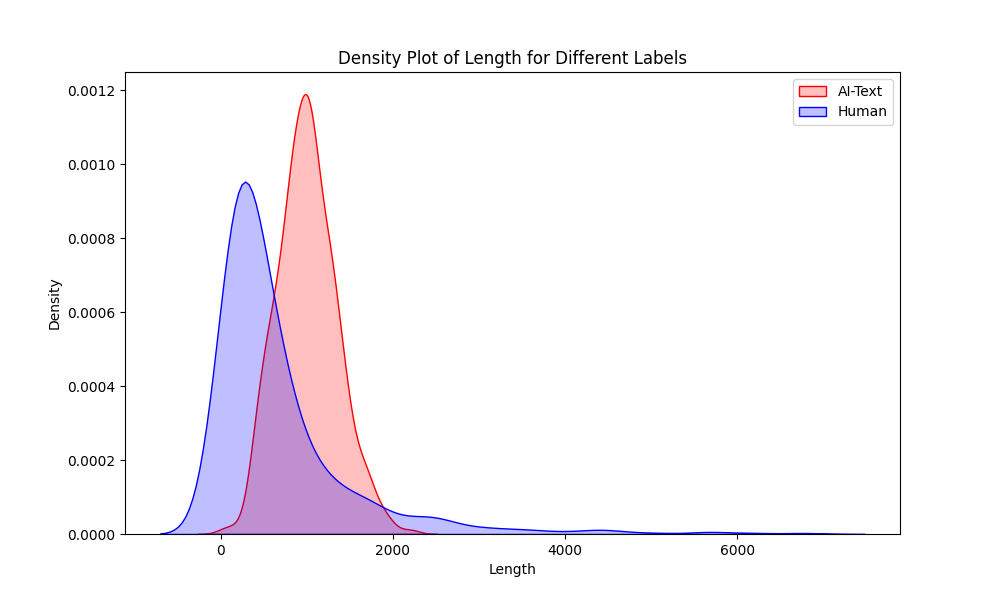

In [39]:
plt.figure(figsize=(10, 6))
sns.kdeplot(analysis_dataset.query('label == 1')['length'], label='AI-Text', shade=True, color='red')
sns.kdeplot(analysis_dataset.query('label == 0')['length'], label='Human', shade=True, color='blue')

plt.title('Density Plot of Length for Different Labels')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()

plt.savefig("src/notebooks/plots/density_plot.png")
plt.show()


# Augmentations analysis

In [40]:
get_dataset_with_model_predictions("FollowUpQGDataset", sample=100)

dataset_name: FollowUpQGDataset


  0%|          | 0/100 [00:00<?, ?it/s]

,index,text,label,piratexx,simpleai,radar,roberta_large,radar_ours,radar_ours_contrastive
0,521,Can you explain a bit more about how the negot...,1,0.000517,0.190548,0.999095,0.500615,0.539821,0.999095
1,739,What happens to the water in the ballast chamb...,1,0.118200,0.994875,0.998978,0.500615,0.540589,0.998978
2,823,What are some common factors apart from abrupt...,1,0.007132,0.030454,0.995983,0.500615,0.542399,0.995981
3,662,Could you explain why the reflections in the m...,1,0.001983,0.999132,0.999270,0.500615,0.540389,0.999270
4,411,So when my plant says it wants to be humid and...,0,0.000784,0.898544,0.979397,0.500615,0.545572,0.979394
...,...,...,...,...,...,...,...,...,...
95,436,I thought carrots were the only vegetable heal...,0,0.000325,0.037796,0.997589,0.500615,0.533632,0.997588
96,894,Can you give more examples of exceptions that ...,1,0.283418,0.989364,0.998638,0.500615,0.539352,0.998637
97,88,"so in other words... If ""normal math"", like (...",0,0.000646,0.000495,0.999145,0.500615,0.521227,0.999145
98,63,"Are you referring to SSAA? Because if you do, ...",0,0.077888,0.214162,0.998100,0.500615,0.546444,0.998099


In [24]:
datasets_to_eval = ["XsumVicuna", "XsumLlama", "FollowUpQGDataset", "ResearchAbstracts", "HC3Dataset", "TwitterBotDataset"]

def get_analysis_with_augmentation(augmentation: callable, N=1000):
    # Get predictions baseline
    results = []
    for dataset in datasets_to_eval:
        df_with_preds = get_dataset_with_model_predictions(dataset, sample=N)
        res_df = get_metrics_per_model(df_with_preds)[['model', 'auc']].rename(columns={'auc': 'Baseline AUC'})
        res_df['dataset'] = dataset

        df_with_preds = get_dataset_with_model_predictions(dataset, sample=N, augmentation=augmentation)
        res_df2 = get_metrics_per_model(df_with_preds)[['model', 'auc']].rename(columns={'auc': 'Augmented AUC'})
        results.append(pd.merge(res_df, res_df2, on='model'))

    return results

In [ ]:
augmentation = create_augmentation_pipeline_proba()
augmentation

In [ ]:
results = get_analysis_with_augmentation(augmentation)

dataset_name: XsumVicuna


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: XsumVicuna


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: XsumLlama


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: XsumLlama


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: FollowUpQGDataset


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: FollowUpQGDataset


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: ResearchAbstracts


  0%|          | 0/1000 [00:00<?, ?it/s]

dataset_name: ResearchAbstracts


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
results

In [ ]:
results_df = pd.concat([*results])

In [ ]:
results_df

In [ ]:
results_df.to_csv('results_augmentation.csv')

In [ ]:
model_name_mapping = {
    "piratexx": "PirateXX",
    "radar": "RADAR-Vicuna-7B",
    "simpleai": "ChatGPT RoBERTa",
    "roberta_large": "RoBERTa Large",
    "radar_ours": "RADAR (ours)",
    "radar_ours_contrastive": "C-RADAR (ours)"
}

In [ ]:
results_df['model'] = results_df['model'].apply(lambda x: model_name_mapping[x])

In [ ]:
results_df

In [ ]:
import matplotlib.pyplot as plt

# Plot the bar chart
ax = results_df.groupby(by='model')[['Baseline AUC', 'Augmented AUC']].mean().plot.bar(figsize=(10, 7))

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  # Format to two decimal places
                (p.get_x() + p.get_width() / 2., p.get_height() * 0.9),  # Position of the annotation
                ha = 'center', va = 'center', 
                xytext=(0, 10),  # Offset of the text
                textcoords='offset points')

plt.tight_layout()
plt.savefig("src/notebooks/plots/augmentation_plot.png", bbox_inches = 'tight')
plt.show()

# Augmentation vs drop

In [25]:
dataset_to_test = pd.concat([
    get_df_sample(dataset, 1000) for dataset in datasets_to_eval] + [twitter_data]).reset_index(drop=True)

dataset_name: XsumVicuna
dataset_name: XsumLlama
dataset_name: FollowUpQGDataset
dataset_name: ResearchAbstracts
dataset_name: HC3Dataset
dataset_name: TwitterBotDataset


In [26]:
dataset_to_test

,index,text,label
0,521.0,Big oil producing nations meet this weekend in...,1
1,737.0,Archaeologists working for the National Trust ...,1
2,740.0,Official figures showed the value of sales ros...,1
3,660.0,The Conservative leader said a future governme...,1
4,411.0,The blaze started at the detached building in ...,0
...,...,...,...
6995,NaN,@MEXC_Global listing @MContent_ on Feb 26 🔥🚀🌙🥳...,1
6996,NaN,RT @fighter_divine: @bitforexcom listed #Bitge...,1
6997,NaN,@bitforexcom listed #Bitgert 🔥🚀🌙\n\n#BRISE #br...,1
6998,NaN,RT @fighter_divine: #btc chart from years 🔥🚀🌙\...,1


#### Compare Augmentations

In [ ]:
augmentations_analysis = []
N = 1000

In [ ]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000, df=dataset_to_test.sample(N).reset_index())
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = None
augmentations_analysis.append(metrics)

In [ ]:
from src.data.transformation.augmentation import RandomNeighbouringWordSwapWithProbability, RandomTypoWithProbability, RandomSpaceWithProbability

In [ ]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomNeighbouringWordSwapWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Word Swap (2% words)"
augmentations_analysis.append(metrics)

In [ ]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomTypoWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Typo (2% letters)"
augmentations_analysis.append(metrics)

In [ ]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomSpaceWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Whitespace (2% letters)"
augmentations_analysis.append(metrics)

In [ ]:
augmentation_results_df = pd.concat(augmentations_analysis)
augmentation_results_df['Augmentation'] = augmentation_results_df['Augmentation'].fillna('None')
augmentation_results_df.groupby(by='Augmentation')[['auc', 'accuracy', 'recall', 'precision', 'f1_score']].mean()

In [ ]:
# existing radar checkpoint is bad on other tests sets than vicuna 7b
# implemention radar from scratch is difficult and it does not work as promised
# radar is not robust to these perturbations
# TODO: perturtbations that change style
# length vs accuracy is not biased
# IN PROGRESS: we train more robust model for twitter data - we don't have that
    # we train model without perturbations in training data
    # we train model with perturbations in training data
    # hypothesis: the second one will be more robust
# 

# Length vs accuracy

In [ ]:
analysis_with_preds = get_dataset_with_model_predictions("xd", df=dataset_to_test)

  0%|          | 0/7000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
def length_vs_accuracy(analysis_with_preds, title):
    # Step 1: Divide the "length" column into 5 equal-sized bins and extract bin ranges
    analysis_with_preds['length'] = analysis_with_preds['text'].apply(lambda x: len(x))
    analysis_with_preds['length_bin'], bin_edges = pd.qcut(analysis_with_preds['length'], q=5, retbins=True, labels=False)
    
    # Step 2: Calculate AUC for each model in each bin
    models = ['piratexx', 'simpleai', 'radar', 'roberta_large']
    auc_results = {}
    
    for model in models:
        auc_per_bin = []
        positive_rate_per_bin = []
        for bin_value in range(5):
            # Filter rows that belong to the current bin
            bin_data = analysis_with_preds[analysis_with_preds['length_bin'] == bin_value]
            len_samples_balanced = min(len(bin_data.query('label == True')), len(bin_data.query('label == False')))
            bin_data_balanced = pd.concat([
                bin_data.query('label == True').sample(len_samples_balanced),
                bin_data.query('label == False').sample(len_samples_balanced)
            ])
            # Calculate AUC for the model in the current bin
            auc = roc_auc_score(bin_data_balanced['label'], bin_data_balanced[model])
            positive_rate_per_bin.append(bin_data_balanced['label'].mean())
            auc_per_bin.append(auc)
        
        auc_results[model] = auc_per_bin
    
    # Step 3: Plot the results with bin ranges as x-axis labels
    bin_ranges = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges)-1)]
    
    plt.figure(figsize=(12, 6))
    
    # Plot AUC results for each model
    for model, aucs in auc_results.items():
        plt.plot(bin_ranges, aucs, marker='o', label=model)
    
    # Add labels and title
    plt.xlabel('Text Length')
    plt.ylabel('AUC')
    plt.title(title)
    plt.xticks(np.arange(len(bin_ranges)), bin_ranges, rotation=45)
    plt.legend(title='Model')
    
    # Show plot
    plt.grid(True)
    plt.savefig(f"src/notebooks/plots/{model}_text_length_vs_auc.png", bbox_inches = 'tight')
    plt.show()

    return positive_rate_per_bin

In [ ]:
length_vs_accuracy(analysis_with_preds, 'AUC vs Text Length. Each bin balanced to 50% positive rate')